# <center> Image Sentiment Classification <center>

## Importing important libraries and setting up dependencies

In [1]:
import tensorflow as tf
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# Avoiding OOM error by limiting vram use by model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Removing Noisy Images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'data'

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
# We are going to use os to go through our data
#os.listdir(os.path.join(data_dir, 'Happy'))

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## Load Data

In [5]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 12045 files belonging to 2 classes.


In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
# Images represented as numpy arrays
batch = data_iterator.next()

In [8]:
batch[0].shape

(32, 256, 256, 3)

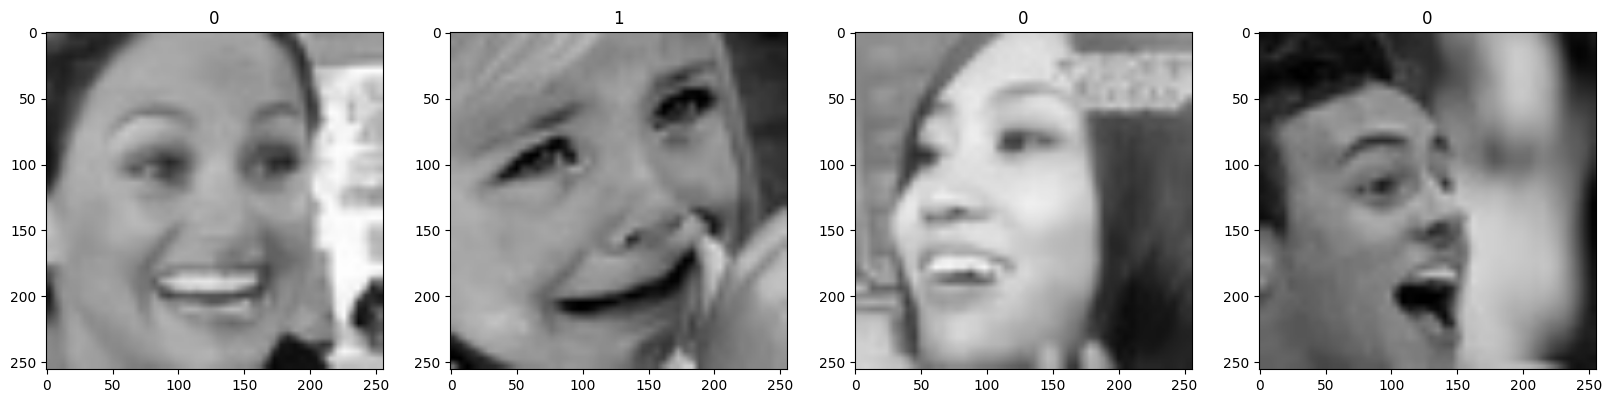

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocessing/Scaling

In [10]:
# we scale the image values between 0 and 1 instead of 0-255 because it helps our deep learning model genralize faster and produce better results
data = data.map(lambda x,y: (x/255, y))

In [11]:
scaled_iterator = data.as_numpy_iterator()

In [12]:
batch = scaled_iterator.next()

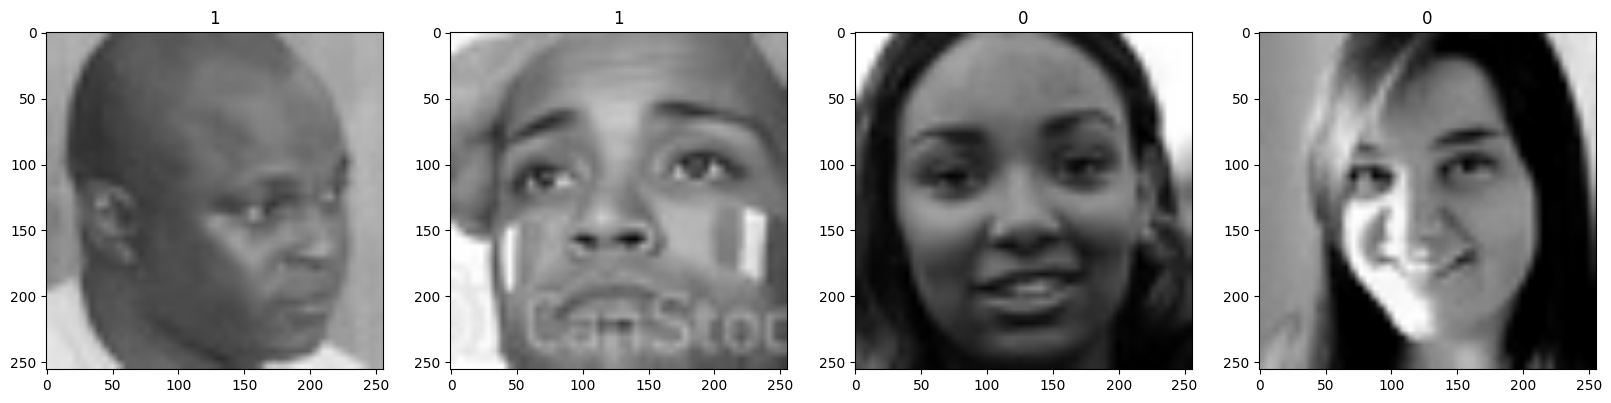

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Train Test Split

In [14]:
len(data)

377

In [15]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [17]:
len(test)

37

## Deep Learning Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [29]:
model = Sequential()

In [30]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 16)       

## Training the model

In [33]:
logdir='logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
263/263 [==============================] - 20s 71ms/step - loss: 0.8274 - accuracy: 0.6011 - val_loss: 0.7176 - val_accuracy: 0.6221
Epoch 2/20
263/263 [==============================] - 20s 77ms/step - loss: 0.6851 - accuracy: 0.6306 - val_loss: 0.6940 - val_accuracy: 0.6708
Epoch 3/20
263/263 [==============================] - 34s 127ms/step - loss: 0.6687 - accuracy: 0.6540 - val_loss: 0.6524 - val_accuracy: 0.6825
Epoch 4/20
263/263 [==============================] - 32s 120ms/step - loss: 0.6680 - accuracy: 0.6636 - val_loss: 0.6398 - val_accuracy: 0.6917
Epoch 5/20
263/263 [==============================] - 30s 114ms/step - loss: 0.6567 - accuracy: 0.6693 - val_loss: 0.6357 - val_accuracy: 0.6983
Epoch 6/20
263/263 [==============================] - 30s 112ms/step - loss: 0.6535 - accuracy: 0.6723 - val_loss: 0.6383 - val_accuracy: 0.6983
Epoch 7/20
263/263 [==============================] - 23s 84ms/step - loss: 0.6473 - accuracy: 0.6843 - val_loss: 0.6294 - val_accur

## Plotting Performance

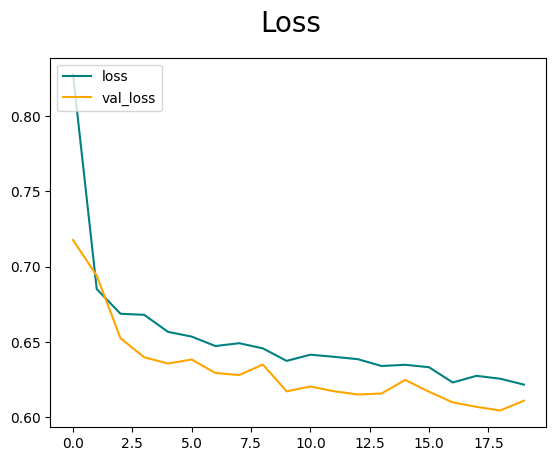

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

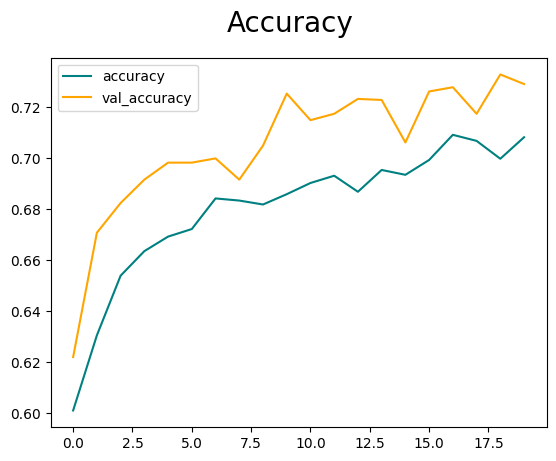

In [37]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluation

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [41]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.70660144, shape=(), dtype=float32) tf.Tensor(0.6046025, shape=(), dtype=float32) tf.Tensor(0.7390203, shape=(), dtype=float32)


## Test

In [43]:
import cv2

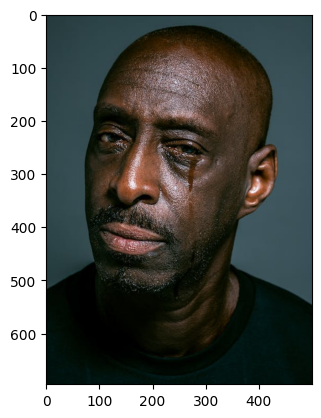

In [44]:
img = cv2.imread('sadtest.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

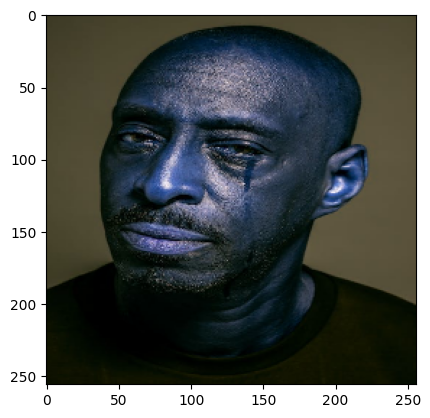

In [45]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [47]:
yhat

array([[0.57862055]], dtype=float32)

In [48]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


## Saving the model

In [51]:
from tensorflow.keras.models import load_model

In [49]:
model.save(os.path.join('models','imageclassifier_tunedforfaces.h5'))

In [52]:
new_model = load_model(os.path.join('models', 'imageclassifier_tunedforfaces.h5'))

In [53]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.57862055]], dtype=float32)

## Loading the model again for further use

In [ ]:
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

## Live webcam facetracking and sentiment classification

In [9]:
import cv2

In [56]:
#face detection usuing cascade method and sentiment classification at the same time.
cap = cv2.VideoCapture(0) # 0 for the number of webcams
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
#eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

while True:
    ret, frame = cap.read()
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),5)
        roi_gray =gray[y:y+w, x:x+w]
        roi_color = frame[y:y+w, x:x+w]# we make this because the orignal image has different number of frames compared to gray image
        roi_color = tf.image.resize(roi_color, (256,256))
        
        prediction = new_model.predict(np.expand_dims(roi_color/255, 0))
        text = prediction[0][0]
        
        if text > 0.5:
            text = "SAD"
        else:
            text = "Happy"
        
        cv2.putText(frame, str(text), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 5, cv2.LINE_AA)
         
            
    cv2.imshow('result', frame)

    
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### Earlier when our model had no regularization and dropout layers, it was overfitting, on using l2 regularization and dropouts we were able to achieve 70% accuracy and live test was also a success.